In [1]:
import os

import pandas as pd
import geopandas as gpd

sys.path.append('..')
from config import *

In [2]:
regressor_area = gpd.read_file(os.path.join(ENTR_DATA_PATH,'Bairros_rio_de_janeiro.shp'))
regressor_area = regressor_area.set_crs(epsg=29183)
regressor_area = regressor_area.to_crs(epsg=4326)
regressor = regressor_area[['area','geometry']]
regressor.head()

,area,geometry
0,1.705684e+06,"MULTIPOLYGON (((-43.10530 -22.74839, -43.10531..."
1,4.056403e+06,"MULTIPOLYGON (((-43.17133 -22.77613, -43.17133..."
2,9.780466e+05,"MULTIPOLYGON (((-43.18878 -22.78270, -43.18876..."
3,1.895742e+07,"MULTIPOLYGON (((-43.22767 -22.78325, -43.22761..."
4,1.672546e+06,"POLYGON ((-43.18002 -22.79891, -43.18018 -22.7..."


In [3]:
df = gpd.read_file(os.path.join(ENTR_DATA_PATH,'sh','sh.shp'))
df.rename({'h3_index':'discr_id'},axis=1,inplace=True)

discretization = df[['discr_id','geometry']].copy()

In [48]:
def addRegressorWeithedAverage(df : gpd.GeoDataFrame, regressor_df : gpd.GeoDataFrame) -> gpd.GeoDataFrame:


    '''
    Apply parameters from regressor database to geographic discretization as a wieghted average of the areas of intersection.

    Parameters
        df : gpd.GeoDataFrame - geodataframe containing the final geographic discretization and a columns 'discr_id' containing unique IDs.
        regressor_df : gpd.GeoDataFrame - geodataframe containing the desired regressors and geometries defining geographic boundaries.

    Returns
        overlay_df : gpd.GeoDataFrame - geodataframe with same structure as df with new columns of applied regressors.

    '''

    # merge calculating area overlays
    overlay_df = gpd.overlay(discretization,regressor,how='intersection').rename({'geometry':'geometry_overlay'},axis=1)
    # merge with df to get original discretization
    overlay_df = pd.merge(
        overlay_df,
        df,
        on='discr_id',
        how='outer'
    ).rename({'geometry':'geometry_discr'},axis=1)

    # complete area zero for non overlay dicretizations
    overlay_df['geometry_overlay_area'] = overlay_df['geometry_overlay'].area.copy()
    overlay_df.loc[overlay_df['geometry_overlay'].isna(),'geometry_overlay_area'] = 0

    # calculate percentage of areas on each overlay
    overlay_df['overlay_area_percentage'] = overlay_df['geometry_overlay_area'] / overlay_df['geometry_discr'].area

    # apply regressor columns multiplying merged values with calculated percentages
    regressor_cols = [col for col in regressor_df.columns if not(col in ['geometry','regr_id'])]
    for regressor_col in regressor_cols:
        overlay_df[regressor_col] *= overlay_df['overlay_area_percentage']

    # sum weithed partials and recover original discretization geometries
    discr_geometries = df.set_index('discr_id')['geometry']
    overlay_df = overlay_df.groupby(['discr_id'])[regressor_cols].sum()
    overlay_df['geometry'] = discr_geometries

    return overlay_df.reset_index()

In [36]:
def addRegressorUniformDistribution(df : gpd.GeoDataFrame, regressor_df : gpd.GeoDataFrame) -> gpd.GeoDataFrame:


    '''
    Apply parameters from regressor database to geographic discretization as a uniform distribution of parameters in regressors area.

    Parameters
        df : gpd.GeoDataFrame - geodataframe containing the final geographic discretization and a columns 'discr_id' containing unique IDs.
        regressor_df : gpd.GeoDataFrame - geodataframe containing the desired regressors and geometries defining geographic boundaries.

    Returns
        overlay_df : gpd.GeoDataFrame - geodataframe with same structure as df with new columns of applied regressors.

    '''

    # create regressors ID column
    regressor_df['regr_id'] = list(range(len(regressor_df)))

    # merge calculating area overlays
    overlay_df = gpd.overlay(discretization,regressor,how='intersection').rename({'geometry':'geometry_overlay'},axis=1)
    # merge with df to get original discretization
    overlay_df = pd.merge(
        overlay_df,
        regressor_df[['regr_id','geometry']],
        on='regr_id',
        how='left'
    ).rename({'geometry':'geometry_regr'},axis=1)

    # calculate percentage of regressor areas on each overlay
    overlay_df['overlay_area_percentage'] = overlay_df['geometry_overlay'].area / overlay_df['geometry_regr'].area

    # apply regressor columns multiplying merged values with calculated percentages
    regressor_cols = [col for col in regressor_df.columns if not(col in ['geometry','regr_id'])]
    for regressor_col in regressor_cols:
        overlay_df[regressor_col] *= overlay_df['overlay_area_percentage']

    # sum weithed partials and recover original discretization geometries
    discr_geometries = df.set_index('discr_id')['geometry']
    overlay_df = overlay_df.groupby(['discr_id'])[regressor_cols].sum()
    overlay_df['geometry'] = discr_geometries
    
    return overlay_df.reset_index()

In [37]:
discretization.sample(5)

,discr_id,geometry
184,87a8a06a9ffffff,"POLYGON ((-43.24496 -22.85728, -43.25187 -22.8..."
314,87a8a0215ffffff,"POLYGON ((-43.72853 -22.98584, -43.72109 -22.9..."
17,87a8a06b1ffffff,"POLYGON ((-43.12389 -22.89278, -43.13823 -22.8..."
200,87a8a0699ffffff,"POLYGON ((-43.14307 -22.79452, -43.15740 -22.7..."
230,87a8a0631ffffff,"POLYGON ((-43.27623 -22.96510, -43.29057 -22.9..."


In [38]:
regressor.sample(5)

,area,geometry,regr_id
58,1.747526e+06,"POLYGON ((-43.29768 -22.85857, -43.29887 -22.8...",58
137,1.054475e+06,"POLYGON ((-43.19590 -22.95221, -43.19501 -22.9...",137
102,2.644847e+06,"POLYGON ((-43.26310 -22.89829, -43.26316 -22.8...",102
124,2.493507e+06,"POLYGON ((-43.18107 -22.92902, -43.18043 -22.9...",124
95,1.112903e+06,"POLYGON ((-43.18750 -22.89262, -43.18750 -22.8...",95


<AxesSubplot:>

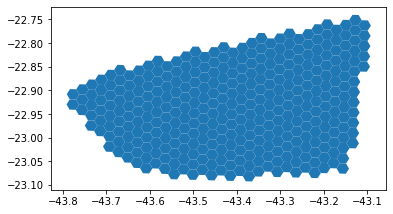

In [39]:
discretization['geometry'].plot()

In [49]:
r2 = addRegressorWeithedAverage(discretization,regressor)

In [50]:
r2.head()

,discr_id,area,geometry
0,87a8a00cbffffff,0.0,"POLYGON ((-43.48699 -23.07905, -43.49442 -23.0..."
1,87a8a00d9ffffff,0.0,"POLYGON ((-43.44398 -23.08016, -43.45141 -23.0..."
2,87a8a00daffffff,0.0,"POLYGON ((-43.40097 -23.08126, -43.40840 -23.0..."
3,87a8a00dbffffff,0.0,"POLYGON ((-43.42221 -23.06988, -43.42964 -23.0..."
4,87a8a0202ffffff,0.0,"POLYGON ((-43.72799 -22.96416, -43.72109 -22.9..."


<AxesSubplot:>

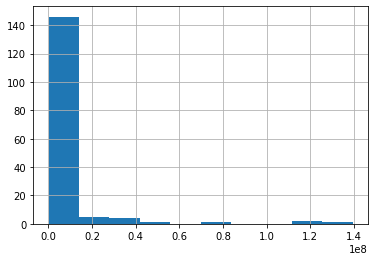

In [59]:
regressor['area'].hist()

<AxesSubplot:>

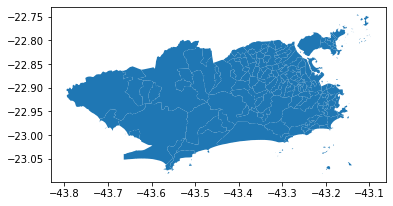

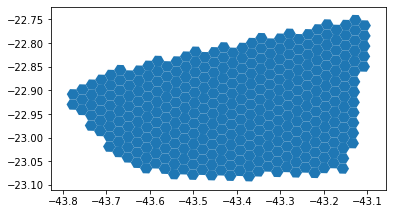

In [51]:
regressor['geometry'].plot()
r2['geometry'].plot()

<AxesSubplot:>

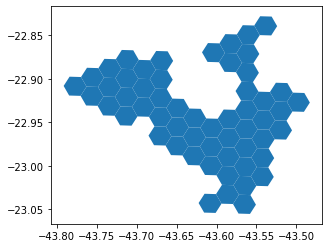

In [62]:
r2[r2['area']>1e8]['geometry'].plot()

<AxesSubplot:>

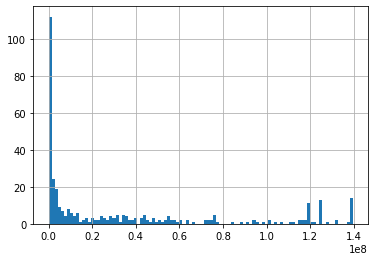

In [57]:
r2['area'].hist(bins=100)